<a href="https://colab.research.google.com/github/sergiopperez/Time_Series_Forecast_Tools/blob/main/Time_Series_Synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecast with LSTM model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


### Generate synthetic data

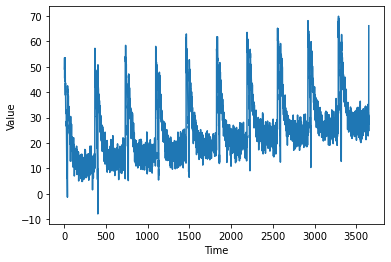

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

### Create function to preprocess the time-series data 

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  print(dataset)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



### Define model based on bidirectional LSTMs

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Define a callback to vary the lr with the epochs. After the training we will 
# decide on the optimal lr for this problem

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model 

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 10ms/step - loss: 8.5331 - mae: 9.0204
Epoch 2/100
94/94 [==============================] - 1s 10ms/step - loss: 8.0548 - mae: 8.5392
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 7.7249 - mae: 8.2080
Epoch 4/100
94/94 [==============================] - 1s 11ms/step - loss: 7.5026 - mae: 7.9862
Epoch 5/100
94/94 [==============================] - 1s 11ms/step - loss: 7.3488 - mae: 7.8287
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 7.2340 - mae: 7.7112
Epoch 7/100
94/94 [==============================] - 1s 11ms/step - loss: 7.1368 - mae: 7.6127
Epoch 8/100
94/94 [==============================] - 1s 12ms/step - loss: 7.0504 - mae: 7.5257
Epoch 9/100
94/94 [==============================] - 1s 10ms/step - loss: 6.9634 - mae: 7.4375
Epoch 10/100
94/94 [==============================] - 1s 10ms/step - loss: 6.8760 - mae: 7.3503
Epoch 11/100
94/94 [=============================

### Plot the lr versus the loss function


(1e-08, 0.0001, 0.0, 30.0)

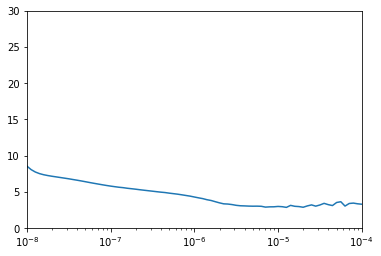

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# From the plot we pick up a lr of 10^{-5}

### Train again the model with the correct lr

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=10**(-5), momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 1s 11ms/step - loss: 263.1988 - mae: 10.1378
Epoch 2/500
94/94 [==============================] - 1s 10ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/500
94/94 [==============================] - 1s 11ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/500
94/94 [==============================] - 1s 10ms/step - loss: 31.9160 - mae: 3.9759
Epoch 5/500
94/94 [==============================] - 1s 11ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/500
94/94 [==============================] - 1s 10ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/500
94/94 [==============================] - 1s 10ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/500
94/94 [==============================] - 1s 10ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/500
94/94 [==============================] - 1s 10ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/500
94/94 [==============================] - 1s 10ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/500
94/94 [=================

### Create forecast vector for the validation set

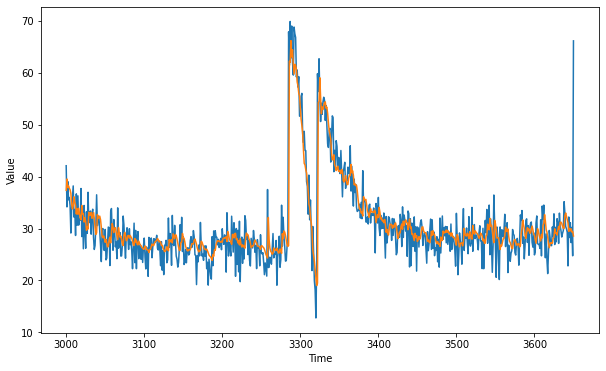

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

### Compute MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# It is less that 4, so it is a good model for this time-series

2.920534

### Plot MAE and Loss function

<Figure size 432x288 with 0 Axes>

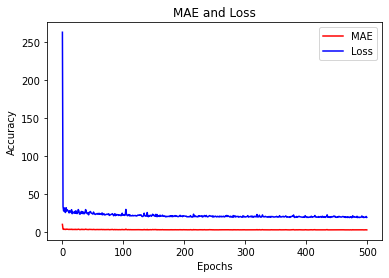

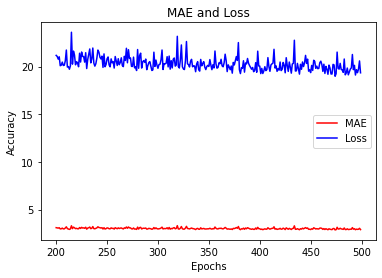

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Extra: a simple linear regression

In [11]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=10**(-5), momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

<TensorSliceDataset shapes: (), types: tf.float32>
Epoch 1/100
94/94 [==============================] - 0s 4ms/step - loss: 277.5613 - mae: 10.5477
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 101.6317 - mae: 5.8482
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 101.2289 - mae: 5.8279
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 101.2633 - mae: 5.8260
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 101.1184 - mae: 5.8324
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 100.8247 - mae: 5.8174
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 100.8326 - mae: 5.8169
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 100.7640 - mae: 5.8175
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 100.5262 - mae: 5.8058
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 100.4518 -

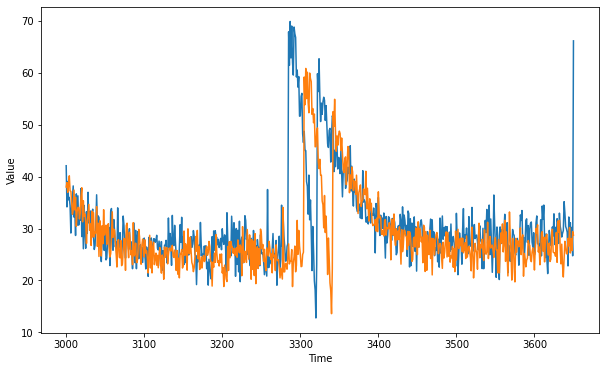

In [10]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, tf.squeeze(results)).numpy()

5.3881345

In [ ]:
x_valid.shape

(651,)

In [ ]:
results.shape

(651, 1)